## Looking into releases and commits

A further analysis of DeepSpeech.

### Imports

In [2]:
import requests as r
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
from tools import *

In [ ]:
from dotenv import load_dotenv
from os import environ
load_dotenv()

In [3]:
g = Github(environ['user'],environ['token'])

In [5]:
commits = [g.get_commits('mozilla/DeepSpeech',{'page':x+1,'per_page':100}).json() for x in range(35)]
len(flatten(commits))

3466

In [17]:
releases = g.get_releases("mozilla/DeepSpeech", {'page':1,'per_page':100}).json()+g.get_releases("mozilla/DeepSpeech", {'page':2,'per_page':100}).json()


# Get and store important information on releases
releases_df = pd.DataFrame(releases).drop([
    'reactions','zipball_url','tarball_url',
    'assets','created_at','draft','assets_url',
    'upload_url','author','node_id',
    'target_commitish','url','id'],axis=1)
releases_df['date'] = pd.to_datetime(releases_df['published_at'])

In [6]:
commits_df = pd.DataFrame([{'name':commit['commit']['author']['name'],
'date':commit['commit']['author']['date'], 
'html_url':commit['html_url'], 
'message': commit['commit']['message']} for commit in flatten(commits)])
commits_df['date'] = pd.to_datetime(commits_df['date'])
commits_df = commits_df.sort_values(by="date")
commits_df

,name,date,html_url,message
3465,Kelly Davis,2016-02-22 11:08:37+00:00,https://github.com/mozilla/DeepSpeech/commit/6...,Initial addition of work in progress
3464,Kelly Davis,2016-05-28 18:12:18+00:00,https://github.com/mozilla/DeepSpeech/commit/7...,Updated bidirectional_rnn() to 0.8 API
3463,Alexandre Lissy,2016-08-09 16:57:46+00:00,https://github.com/mozilla/DeepSpeech/commit/8...,Updating DeepSpeech for 0.10 API
3462,Kelly Davis,2016-08-09 17:11:56+00:00,https://github.com/mozilla/DeepSpeech/commit/6...,Merge pull request #2 from lissyx/tf-0.10\n\nU...
3461,Kelly Davis,2016-08-23 17:38:19+00:00,https://github.com/mozilla/DeepSpeech/commit/3...,Updated use of bidirectional_rnn to API change...
...,...,...,...,...
4,lissyx,2021-05-13 16:09:11+00:00,https://github.com/mozilla/DeepSpeech/commit/9...,Merge pull request #3647 from mozilla/ftyers-p...
3,lissyx,2021-07-30 18:50:45+00:00,https://github.com/mozilla/DeepSpeech/commit/f...,Update conf.py
2,lissyx,2021-07-30 18:50:58+00:00,https://github.com/mozilla/DeepSpeech/commit/7...,Merge pull request #3674 from mozilla/lissyx-p...
1,Daniel Tinazzi,2021-11-17 13:20:19+00:00,https://github.com/mozilla/DeepSpeech/commit/4...,Fixed M-AILABS broken link\n\nI replaced the b...


### Commits and releases
Naturally, after an amount of commits, there would be a release. We do a preliminary study to inspect how the number of releases evolves with the number of commits.

In [7]:
commits_df['dummy'] = 1
commits_df["Number of Releases"] = commits_df['dummy'].cumsum()

<AxesSubplot:xlabel='date', ylabel='Number of Releases'>

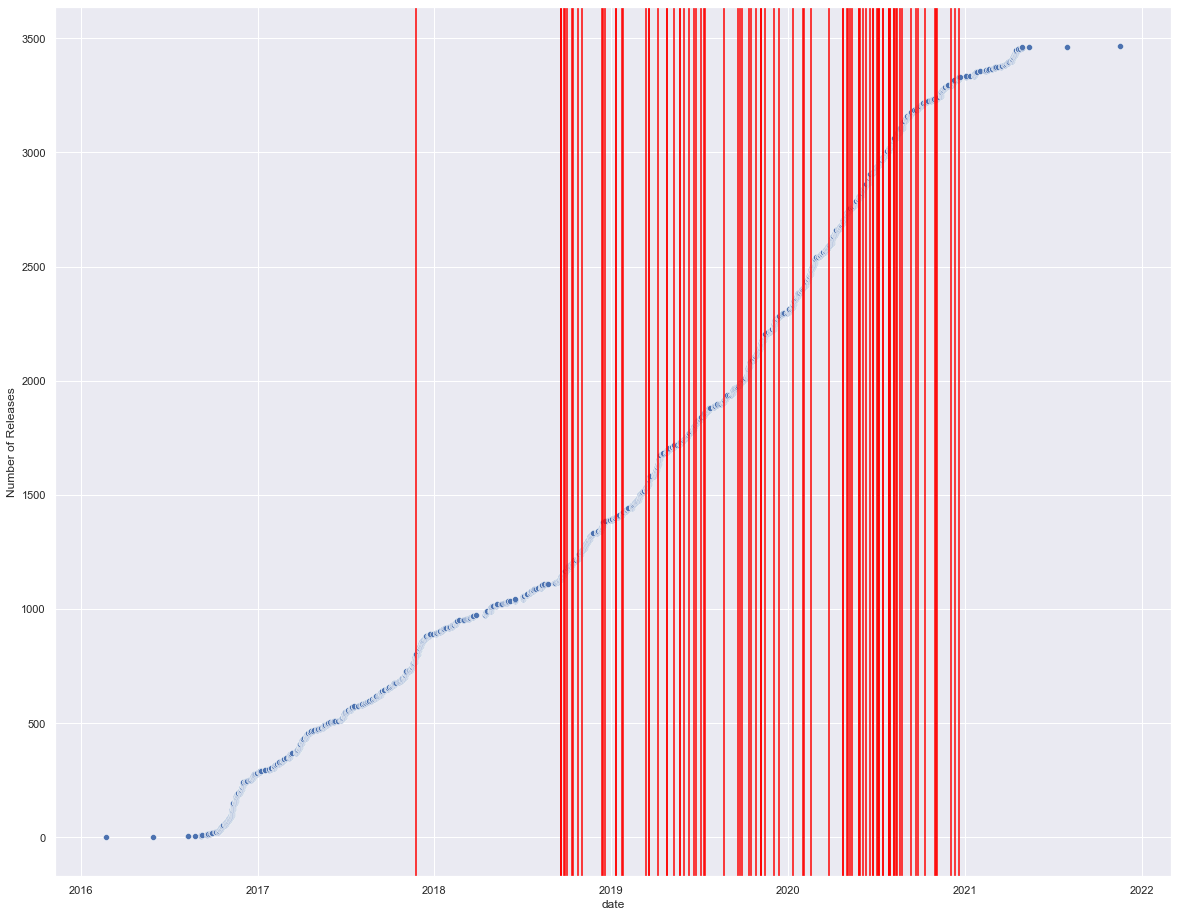

In [19]:
sns.set(rc={'figure.figsize':(20,16)})
for release in list(releases_df['date']): plt.axvline(release,color="red")
sns.scatterplot(data=commits_df,x='date',y='Number of Releases')

We find several things of note. First, is that there was a large period of growth during 2017 up until the end of 2020, and majority of releases occured between the end of 2018 and the end of 2020.

## An attempt to use NLTK

A proposed idea was to use NLTK to summarise text in the release body. We wish to examine the effects of this trial.

In [39]:
from nltk.corpus import stopwords
from nltk.cluster.util import cosine_distance
import numpy as np
import networkx as nx
 
def read_text(text):
    article = text.split(". ")
    sentences = []

    for sentence in article:
        print(sentence)
        sentences.append(sentence.replace("[^a-zA-Z]", " ").split(" "))
    sentences.pop() 
    
    return sentences

def sentence_similarity(sent1, sent2, stopwords=None):
    if stopwords is None:
        stopwords = []
 
    sent1 = [w.lower() for w in sent1]
    sent2 = [w.lower() for w in sent2]
 
    all_words = list(set(sent1 + sent2))
 
    vector1 = [0] * len(all_words)
    vector2 = [0] * len(all_words)
 
    # build the vector for the first sentence
    for w in sent1:
        if w in stopwords:
            continue
        vector1[all_words.index(w)] += 1
 
    # build the vector for the second sentence
    for w in sent2:
        if w in stopwords:
            continue
        vector2[all_words.index(w)] += 1
 
    return 1 - cosine_distance(vector1, vector2)
 
def build_similarity_matrix(sentences, stop_words):
    # Create an empty similarity matrix
    similarity_matrix = np.zeros((len(sentences), len(sentences)))
 
    for idx1 in range(len(sentences)):
        for idx2 in range(len(sentences)):
            if idx1 == idx2: #ignore if both are same sentences
                continue 
            similarity_matrix[idx1][idx2] = sentence_similarity(sentences[idx1], sentences[idx2], stop_words)

    return similarity_matrix


def generate_summary(file_name, top_n=5):
    stop_words = stopwords.words('english')
    summarize_text = []

    # Step 1 - Read text anc split it
    sentences =  read_text(file_name)

    # Step 2 - Generate Similary Martix across sentences
    sentence_similarity_martix = build_similarity_matrix(sentences, stop_words)

    # Step 3 - Rank sentences in similarity martix
    sentence_similarity_graph = nx.from_numpy_array(sentence_similarity_martix)
    scores = nx.pagerank(sentence_similarity_graph)

    # Step 4 - Sort the rank and pick top sentences
    ranked_sentence = sorted(((scores[i],s) for i,s in enumerate(sentences)), reverse=True)    
    print("Indexes of top ranked_sentence order are ", ranked_sentence)    

    for i in range(top_n):
      summarize_text.append(" ".join(ranked_sentence[i][1]))

    # Step 5 - Offcourse, output the summarize texr
    print("Summarize Text: \n", ". ".join(summarize_text))

# let's begin


In [40]:
generate_summary(releases_df.body.iloc[3], 2)

# General

This is the 0.9.1 release of Deep Speech, an open speech-to-text engine
In accord with [semantic versioning](https://semver.org/), this version is not completely backwards compatible with earlier versions
However, models exported for 0.7.X and 0.8.X should work with this release
**This is a bugfix release and retains compatibility with the 0.9.0 models
All model files included here are identical to the ones in the 0.9.0 release.** As with previous releases, this release includes the source code:

[v0.9.1.tar.gz](https://github.com/mozilla/DeepSpeech/archive/v0.9.1.tar.gz)

Under the [MPL-2.0 license](https://www.mozilla.org/en-US/MPL/2.0/)
And the acoustic models:

[deepspeech-0.9.1-models.pbmm](https://github.com/mozilla/DeepSpeech/releases/download/v0.9.1/deepspeech-0.9.1-models.pbmm)
[deepspeech-0.9.1-models.tflite](https://github.com/mozilla/DeepSpeech/releases/download/v0.9.1/deepspeech-0.9.1-models.tflite)

In addition we're releasing experimental Mandarin Chinese acou